In [15]:
!pip install efficientnet

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import efficientnet.keras as enet

# Data Augmentation

In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255) 

In [18]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 4098 images belonging to 4 classes.


In [19]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


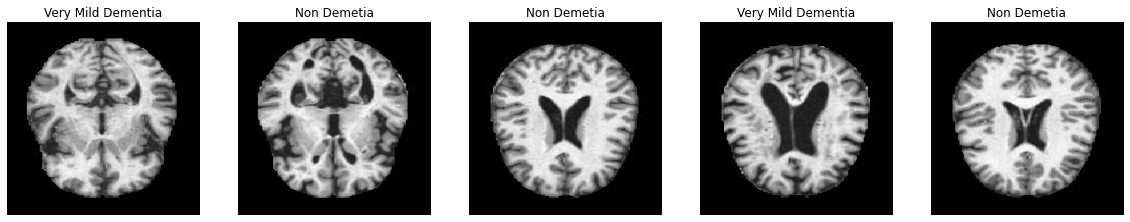

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(64)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [21]:
base_model = enet.EfficientNetB0(input_shape=(224,224,3), 
                                 include_top=False,
                                 weights="imagenet")

In [22]:
for layer in base_model.layers:
    layer.trainable=False

In [23]:
model=Sequential()
model.add(base_model)
model.add(AveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 1280)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 1280)        5120      
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 11520)             46080     
_________________________________________________________________
dense_3 (Dense)              (None, 512)              

In [25]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [26]:
filepath = './model_tuning224_512_Adam1e3.h5'

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [checkpoint]

In [27]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                         
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 1.1416 - auc: 0.8021
Epoch 00001: val_auc improved from -inf to 0.76267, saving model to .\model_tuning224_512_Adam1e3.h5
65/65 [==============================] - 282s 4s/step - loss: 1.1416 - auc: 0.8021 - val_loss: 1.0897 - val_auc: 0.7627
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 0.8306 - auc: 0.8834
Epoch 00002: val_auc did not improve from 0.76267
65/65 [==============================] - 272s 4s/step - loss: 0.8306 - auc: 0.8834 - val_loss: 1.2542 - val_auc: 0.6857
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.7445 - auc: 0.9032
Epoch 00003: val_auc did not improve from 0.76267
65/65 [==============================] - 271s 4s/step - loss: 0.7445 - auc: 0.9032 - val_loss: 1.2180 - val_auc: 0.7136
Epoch 4/100
65/65 [==============================] - ETA: 0s - loss: 0.6622 - auc: 0.9226
Epoch 00004: val_auc did not improve from 0.76267
65/65 [======================

65/65 [==============================] - 267s 4s/step - loss: 0.2277 - auc: 0.9899 - val_loss: 0.6947 - val_auc: 0.9296
Epoch 31/100
65/65 [==============================] - ETA: 0s - loss: 0.2357 - auc: 0.9891
Epoch 00031: val_auc improved from 0.92962 to 0.93804, saving model to .\model_tuning224_512_Adam1e3.h5
65/65 [==============================] - 267s 4s/step - loss: 0.2357 - auc: 0.9891 - val_loss: 0.6425 - val_auc: 0.9380
Epoch 32/100
65/65 [==============================] - ETA: 0s - loss: 0.2268 - auc: 0.9901
Epoch 00032: val_auc did not improve from 0.93804
65/65 [==============================] - 266s 4s/step - loss: 0.2268 - auc: 0.9901 - val_loss: 0.6967 - val_auc: 0.9295
Epoch 33/100
65/65 [==============================] - ETA: 0s - loss: 0.2286 - auc: 0.9898
Epoch 00033: val_auc did not improve from 0.93804
65/65 [==============================] - 265s 4s/step - loss: 0.2286 - auc: 0.9898 - val_loss: 0.7001 - val_auc: 0.9293
Epoch 34/100
65/65 [=======================

Epoch 61/100
65/65 [==============================] - ETA: 0s - loss: 0.1533 - auc: 0.9951
Epoch 00061: val_auc did not improve from 0.95182
65/65 [==============================] - 171s 3s/step - loss: 0.1533 - auc: 0.9951 - val_loss: 0.6001 - val_auc: 0.9471
Epoch 62/100
65/65 [==============================] - ETA: 0s - loss: 0.1479 - auc: 0.9953
Epoch 00062: val_auc did not improve from 0.95182
65/65 [==============================] - 171s 3s/step - loss: 0.1479 - auc: 0.9953 - val_loss: 0.6247 - val_auc: 0.9440
Epoch 63/100
65/65 [==============================] - ETA: 0s - loss: 0.1361 - auc: 0.9963
Epoch 00063: val_auc did not improve from 0.95182
65/65 [==============================] - 171s 3s/step - loss: 0.1361 - auc: 0.9963 - val_loss: 0.7497 - val_auc: 0.9260
Epoch 64/100
65/65 [==============================] - ETA: 0s - loss: 0.1469 - auc: 0.9957
Epoch 00064: val_auc improved from 0.95182 to 0.95435, saving model to .\model_tuning224_512_Adam1e3.h5
65/65 [===============

65/65 [==============================] - 168s 3s/step - loss: 0.1097 - auc: 0.9974 - val_loss: 0.5263 - val_auc: 0.9605
Epoch 92/100
65/65 [==============================] - ETA: 0s - loss: 0.1159 - auc: 0.9970
Epoch 00092: val_auc did not improve from 0.96051
65/65 [==============================] - 169s 3s/step - loss: 0.1159 - auc: 0.9970 - val_loss: 0.5585 - val_auc: 0.9549
Epoch 93/100
65/65 [==============================] - ETA: 0s - loss: 0.0955 - auc: 0.9983
Epoch 00093: val_auc did not improve from 0.96051
65/65 [==============================] - 168s 3s/step - loss: 0.0955 - auc: 0.9983 - val_loss: 0.6093 - val_auc: 0.9503
Epoch 94/100
65/65 [==============================] - ETA: 0s - loss: 0.1237 - auc: 0.9969
Epoch 00094: val_auc did not improve from 0.96051
65/65 [==============================] - 169s 3s/step - loss: 0.1237 - auc: 0.9969 - val_loss: 0.6238 - val_auc: 0.9475
Epoch 95/100
65/65 [==============================] - ETA: 0s - loss: 0.1229 - auc: 0.9966
Epoch 

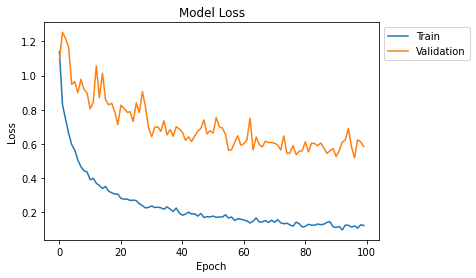

In [28]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

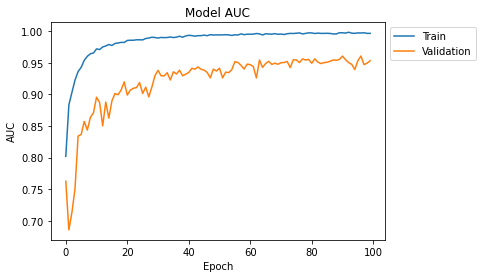

In [29]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

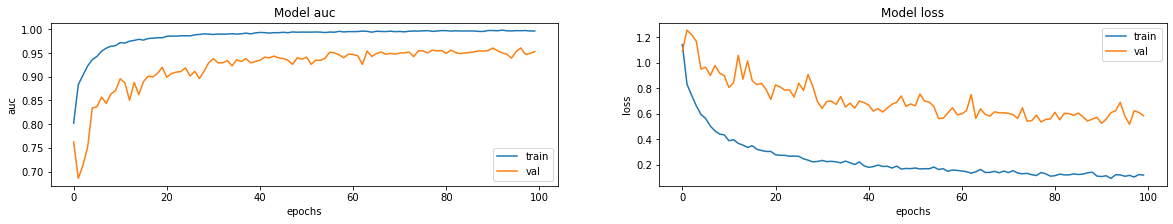

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(model_history.history[met])
    ax[i].plot(model_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 64)

Found 1279 images belonging to 4 classes.


In [32]:
model.evaluate(test_dataset)

20/20 [==============================] - 39s 2s/step - loss: 0.9081 - auc: 0.9243


[0.9080769419670105, 0.924345850944519]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
99.98 % chances are there that the image is NonDemented


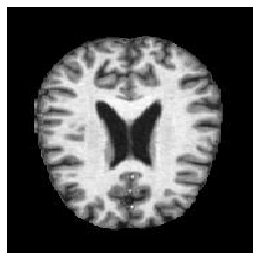

In [33]:
# Test Case 1: Non-Dementia

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

87.2 % chances are there that the image is MildDemented


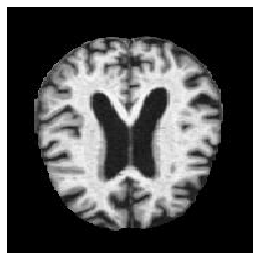

In [34]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

100.0 % chances are there that the image is ModerateDemented


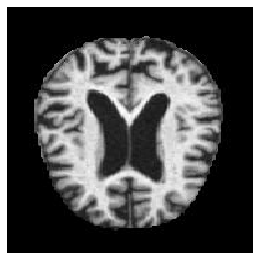

In [35]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

99.83 % chances are there that the image is VeryMildDemented


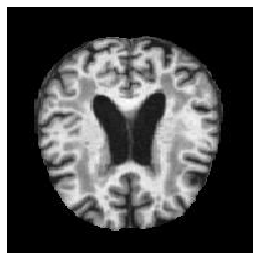

In [36]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])